In [38]:
import os
cwd = os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2
import re
import shutil
import random
import torch
import torchvision
import time
import copy
from PIL import Image

# Download and Preview Data

In [3]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2020-12-28 03:43:40--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.96.219
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.96.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  34.0MB/s    in 7.3s    

2020-12-28 03:43:48 (31.4 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [4]:
!unzip *.zip && rm *.zip

Archive:  5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [ ]:
!unrar x *.rar && rm *.rar

In [6]:
crack_images = os.listdir('Positive/')
no_crack_images = os.listdir('Negative/')
print("Number of Crack Images: ", len(crack_images))
print("Number of No Crack Images: ", len(no_crack_images))

Number of Crack Images:  20000
Number of No Crack Images:  20000


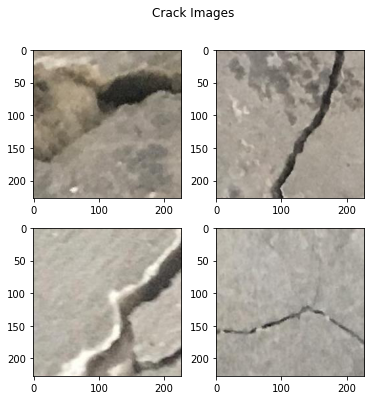

In [7]:
fig, ax = plt.subplots(2,2, figsize=(6,6))
fig.suptitle('Crack Images')

ax[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', crack_images[0])))
ax[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', crack_images[1])))
ax[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', crack_images[2])))
ax[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', crack_images[3])))

plt.show()

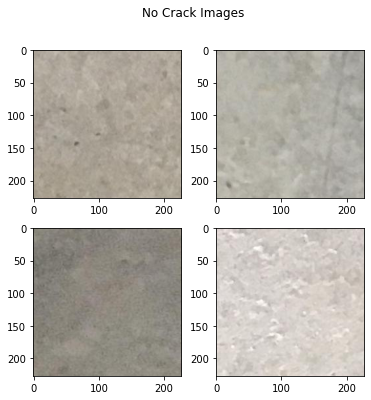

In [8]:
fig, ax = plt.subplots(2,2, figsize=(6,6))
fig.suptitle('No Crack Images')

ax[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', no_crack_images[0])))
ax[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', no_crack_images[1])))
ax[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', no_crack_images[2])))
ax[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', no_crack_images[3])))

plt.show()

# Create Train and Test Dataset

## Training Folder

In [9]:
def create_training_data(folder_name):
    train_dir = f"{cwd}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{cwd}/{folder_name}', train_dir)

In [10]:
files = os.listdir(cwd)

create_training_data('Positive')
create_training_data('Negative')

## Validation Folder

In [11]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

positive_train = cwd + "/train/Positive/"
positive_val = cwd + "/val/Positive/"
negative_train = cwd + "/train/Negative/"
negative_val = cwd + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

# Load and Transform Data with PyTorch

In [12]:
from torchvision import transforms

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(size=227), # Crop the given image to random size and aspect ratio
                                                  transforms.RandomRotation(degrees=10), # Rotate image
                                                  transforms.RandomHorizontalFlip(), # Flip horizontally
                                                  transforms.RandomVerticalFlip(), # Flip vertically 
                                                  transforms.ColorJitter(brightness=0.15, contrast=0.15), # Change brightness and contrast
                                                  transforms.ToTensor(), # Convert to tensor
                                                  transforms.Normalize(mean_nums, std_nums)]), # Normalize image
                      
                     'val': transforms.Compose([transforms.Resize(227),
                                                transforms.CenterCrop(227),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean_nums, std_nums)])}

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
from torchvision import datasets
from torch.utils.data import DataLoader

def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(root=data_path,
                                   transform=chosen_transforms[format])
    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             num_workers=4,
                             shuffle=True)
    return data_loader, len(dataset), dataset.classes

In [17]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size : ", train_size)
print("Class Names : ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size :  31878
Class Names :  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


## Visualize Augmented Data

In [22]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

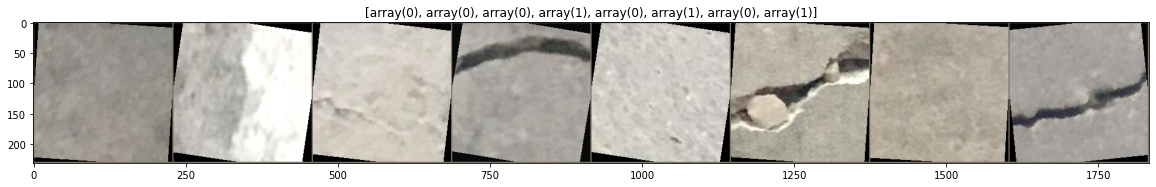

In [23]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

# Setup Pretrained Model

**Resnet50 Architecture:**

![](https://www.researchgate.net/publication/338603223/figure/fig1/AS:847598516711425@1579094642237/ResNet-50-architecture-26-shown-with-the-residual-units-the-size-of-the-filters-and.png)

In [24]:
from torchvision import models
import torch.nn as nn
from torchsummary import summary

resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of the resnet model
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(nn.Linear(fc_inputs, 128),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(128, 2))

# Convert model to be used on GPU
resnet50 = resnet50.to(device)
summary(resnet50, (3, 227, 227))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256

In [25]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [33]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

# Train Model

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradient
                optimizer.zero_grad()

                # Forward training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # Hold the loss stats
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model weight
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
                    
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...
train Loss: 0.3001 Acc: 0.8794
Iterating through data...
val Loss: 0.0856 Acc: 0.9789

Epoch 1/5
----------
Iterating through data...
train Loss: 0.1908 Acc: 0.9309
Iterating through data...
val Loss: 0.0794 Acc: 0.9813

Epoch 2/5
----------
Iterating through data...
train Loss: 0.1826 Acc: 0.9331
Iterating through data...
val Loss: 0.0736 Acc: 0.9814

Epoch 3/5
----------
Iterating through data...
train Loss: 0.1783 Acc: 0.9349
Iterating through data...
val Loss: 0.0800 Acc: 0.9791

Epoch 4/5
----------
Iterating through data...
train Loss: 0.1744 Acc: 0.9383
Iterating through data...
val Loss: 0.0720 Acc: 0.9820

Epoch 5/5
----------
Iterating through data...
train Loss: 0.1689 Acc: 0.9382
Iterating through data...
val Loss: 0.0706 Acc: 0.9818

Training complete in 18m 38s
Best val Acc: 0.982024


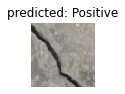

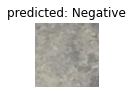

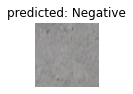

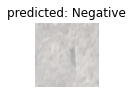

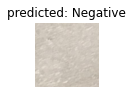

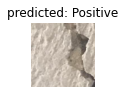

In [34]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

# Predict Real Images

In [39]:
def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['val']
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)

    return class_name

def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            
            predicted_class = predict(base_model,Image.fromarray(a))
            
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [ ]:
!wget -O images1.jpg https://adigaskell.org/wp-content/uploads/2018/01/cracks-road.jpg
!wget -O images2.jpg https://p1.pxfuel.com/preview/609/313/293/asphalt-road-cracks-cracked-stones-broken.jpg
!wget -O images3.jpg https://i2-prod.examinerlive.co.uk/incoming/article17819267.ece/ALTERNATES/s1200b/0_JS207498070.jpg

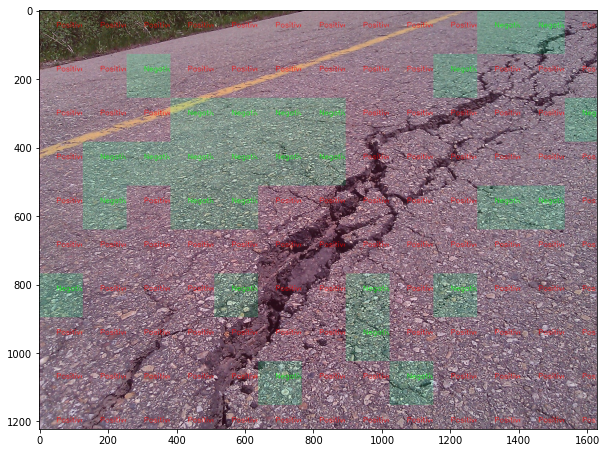

In [40]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('images1.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

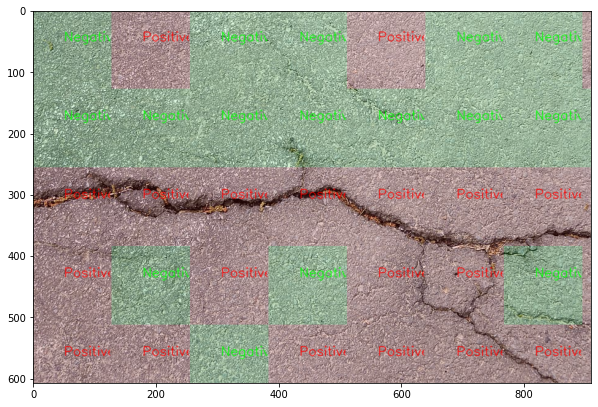

In [41]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('images2.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

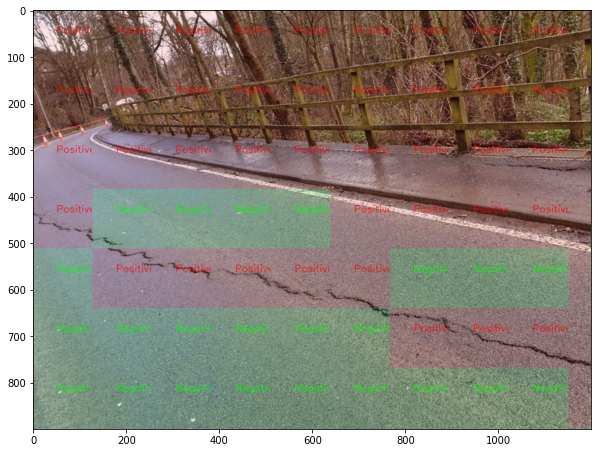

In [43]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('images3.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))